In [110]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix 
from scipy import stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [111]:
# read data
claim_df =  pd.read_csv("./data/ClaimLevel.csv")
policy_df = pd.read_csv("./data/PolicyLevel.csv")

"""
                        # Data Preparation & Feature generation#
Generate a single record per policy that retains max information possible
"""
claim_df['CustomerPaidAmount'] = claim_df['ClaimedAmount'] - claim_df['PaidAmount']
claim_df_grouped = claim_df.groupby(['PolicyId'])
claim_per_policy_df = claim_df_grouped[['ClaimedAmount', 'PaidAmount', 'CustomerPaidAmount']].sum()
claim_per_policy_df['ClaimsCount'] = claim_df_grouped.size()
claim_per_policy_df['AvgClaimAmount'] = claim_df_grouped[['ClaimedAmount']].mean()
claim_per_policy_df['AvgPaidAmount'] = claim_df_grouped[['PaidAmount']].mean()
claim_per_policy_df['AvgCustomerPaidAmount'] = claim_df_grouped[['CustomerPaidAmount']].mean()
claim_per_policy_df['stdClaimAmount'] = claim_df_grouped[['ClaimedAmount']].std()
claim_per_policy_df['stdPaidAmount'] = claim_df_grouped[['PaidAmount']].std()
claim_per_policy_df['stdCustomerPaidAmount'] = claim_df_grouped[['CustomerPaidAmount']].std()
claim_per_policy_df['VarianceClaimAmount'] = claim_df_grouped[['ClaimedAmount']].var()
claim_per_policy_df['VariancePaidAmount'] = claim_df_grouped[['PaidAmount']].var()
claim_per_policy_df['VarianceCustomerPaidAmount'] = claim_df_grouped[['CustomerPaidAmount']].var()
claim_per_policy_df['maxClaimAmount'] = claim_df_grouped[['ClaimedAmount']].max()
claim_per_policy_df['minClaimAmount'] = claim_df_grouped[['ClaimedAmount']].min()
claim_per_policy_df['medianClaimAmount'] = claim_df_grouped[['ClaimedAmount']].median()
claim_per_policy_df['maxCustomerPaidAmount'] = claim_df_grouped[['ClaimedAmount']].max()
claim_per_policy_df['minCustomerPaidAmount'] = claim_df_grouped[['ClaimedAmount']].min()
claim_per_policy_df['medianCustomerPaidAmount'] = claim_df_grouped[['ClaimedAmount']].median()

policy_df = policy_df.join(claim_per_policy_df, on=['PolicyId'])


# Last seen Date: CancelDate if not null else '2016-12-31' (Last date in the data set)
policy_df['LastSeenDate'] = policy_df['CancelDate']
policy_df['LastSeenDate'].fillna(pd.to_datetime('2016-12-31'), inplace=True)

# Date conversions
policy_df['EnrollDate'] = pd.to_datetime(policy_df['EnrollDate'])
policy_df['CancelDate'] = pd.to_datetime(policy_df['CancelDate'])
policy_df['LastSeenDate'] = pd.to_datetime(policy_df['LastSeenDate'])

# Length of Stay "LOS"
policy_df['LOS'] = ((policy_df['LastSeenDate'] - policy_df['EnrollDate'])/np.timedelta64(1, 'M'))
policy_df = policy_df.round(decimals=2)

# Insurance Status: Active means 1 else 0
policy_df['InsuranceStatus'] = policy_df['CancelDate'].apply(lambda x: 1 if pd.notnull(x) else 0)

# drop null values
policy_df.dropna(axis='index', subset=['MonthlyPremium'], inplace=True)

# If no claims were made then all amounts are equal to 0 instead of NULL
for column in policy_df.columns:
    policy_df[column].fillna(0, inplace=True)

# display(claim_df.head())
display(policy_df.head(6))

,PolicyId,EnrollDate,CancelDate,MonthlyPremium,ClaimedAmount,PaidAmount,CustomerPaidAmount,ClaimsCount,AvgClaimAmount,AvgPaidAmount,...,VarianceCustomerPaidAmount,maxClaimAmount,minClaimAmount,medianClaimAmount,maxCustomerPaidAmount,minCustomerPaidAmount,medianCustomerPaidAmount,LastSeenDate,LOS,InsuranceStatus
0,92597,2010-12-07,1970-01-01,34.54,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2016-12-31,72.81,0
1,92808,2010-11-09,1970-01-01,18.54,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2016-12-31,73.73,0
2,93090,2010-11-11,1970-01-01,23.53,762.49,329.46,433.03,3.0,254.16,109.82,...,7971.91,510.48,100.00,152.01,510.48,100.00,152.01,2016-12-31,73.66,0
3,93122,2010-11-11,1970-01-01,44.02,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2016-12-31,73.66,0
4,93133,2010-11-11,1970-01-01,32.46,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2016-12-31,73.66,0
5,93258,2010-11-11,2016-05-24,21.66,33.99,30.60,3.39,3.0,11.33,10.20,...,0.00,11.33,11.33,11.33,11.33,11.33,11.33,2016-05-24,66.40,1


In [112]:
"""
                   # Data Description #
Churn --> 'C' 
Non-Churn --> 'NC'
"""
total_policies = policy_df.shape[0]
curr_NC = policy_df[policy_df['InsuranceStatus']==0].shape[0]/float(total_policies)
curr_C = policy_df[policy_df['InsuranceStatus']==1].shape[0]/float(total_policies)
print("Total polices", total_policies)
print("NC:C = ",curr_NC, ":", curr_C)

Total polices 99995
NC:C =  0.8678433921696085 : 0.13215660783039151


In [113]:
churn_data = policy_df[policy_df['InsuranceStatus']==1]
non_churn_data = policy_df[policy_df['InsuranceStatus']==0]
train_data = pd.concat([churn_data, non_churn_data.sample(n=len(churn_data))], axis=1)
test_data = policy_df.loc[np.setdiff1d(policy_df.index.values, churn_data.index.values),:]
len(train_data)+len(test_data)
# len(policy_df)

113210

In [114]:
"""
                   # Data Description #
Churn --> 'C' 
Non-Churn --> 'NC'
"""
total_policies = policy_df.shape[0]
curr_NC = policy_df[policy_df['InsuranceStatus']==0].shape[0]/float(total_policies)
curr_C = policy_df[policy_df['InsuranceStatus']==1].shape[0]/float(total_policies)
print("Total polices", total_policies)
print("NC:C = ",curr_NC, ":", curr_C)

Total polices 99995
NC:C =  0.8678433921696085 : 0.13215660783039151


In [115]:
# Sampling Data
churn_indices = policy_df[policy_df['InsuranceStatus']==1].index.values
nonchurn_indices = policy_df[policy_df['InsuranceStatus']==0].index.values
# print(len(churn_indices), len(nonchurn_indices))

def sample_train_data(num_samples=None, churn_percent=None):
    """
    :param num_samples: total number of samples to return
    :param nc: ratio of non-churn in the return data set
    :param c: ration of churn in the return data set
    """
    # check to see if nc + c = 1
    churn_sample_space = churn_indices
    non_churn_sample_space = nonchurn_indices
        
    if num_samples is None and churn_percent is None:
        # use max samples possible (only 80% for train)
        churn_percent = curr_C 
        num_samples = int(len(churn_indices)*0.8/churn_percent)
    elif num_samples is None:
        num_samples = int(len(churn_indices)*0.8/churn_percent)
    
    if churn_percent==None:
        # default rate
        churn_percent = curr_C 
    elif churn_percent > 1:
        raise ValueError('Churn percent cannot be > 1')
    
    non_churn_percent = 1 - churn_percent
    nc_samples_count = int(num_samples * non_churn_percent)
    c_samples_count = int(num_samples * churn_percent)
    
    
    # prune train indices if looking for test set
    churn_sample_indices = np.random.choice(churn_sample_space, size=c_samples_count, replace=False)
    nonchurn_sample_indices = np.random.choice(non_churn_sample_space, size=nc_samples_count, replace=False)
    sample_indices = np.concatenate((churn_sample_indices, nonchurn_sample_indices))
    # shuffle
    np.random.shuffle(sample_indices)
    sample = policy_df.loc[sample_indices, :]
    return sample

def sample_test_data(skip_indices=[]):
    
    churn_sample_space = np.setdiff1d(churn_indices, skip_indices)
    non_churn_sample_space = np.setdiff1d(nonchurn_indices, skip_indices)
    churn_sample_indices = churn_sample_space
    nonchurn_sample_indices = np.random.choice(non_churn_sample_space, size=len(churn_sample_indices), replace=False)
    sample_indices = np.concatenate((churn_sample_indices, nonchurn_sample_indices))
    # shuffle
    np.random.shuffle(sample_indices)
    sample = policy_df.loc[sample_indices, :]
    return sample
    
# test case
test = True
if test == False:
#     sample = sample_data(100, 0.8, 0.2)
    sample = sample_data()
    sample.head()
    sample_total_policies = sample.shape[0]
    NC = sample[sample['InsuranceStatus']==0].shape[0]/float(sample_total_policies)
    C = sample[sample['InsuranceStatus']==1].shape[0]/float(sample_total_policies)
    print("Total polices", total_policies)
    print("NC:C = ",NC, ":", C)

In [118]:
select_columns = list(
    set(policy_df.columns) - set(['PolicyId', 'EnrollDate', 'CancelDate', 'InsuranceStatus', 'LastSeenDate',
#                                  'ClaimedAmount', 'PaidAmount', 'CustomerPaidAmount' , 
#                                  'AvgClaimAmount', 'AvgPaidAmount', 'stdClaimAmount', 'stdPaidAmount'
#                                   'minClaimAmount', 'maxClaimAmount', 'medianClaimAmount'
                                 ]))
policy_df[select_columns] = scaler.fit_transform(policy_df[select_columns])

# From the train data evaluation this the best set
# # data set 2: NC:C = 1:1 and contains max samples possible
train_set2_df = sample_train_data(churn_percent=0.5)
test_set2_df = sample_test_data(skip_indices=train_set2_df.index.values)

datasets  = [
        [train_set2_df, test_set2_df],
        ]

In [119]:
"""
                                        # Logistic Model parameter tuning#
"""
from sklearn.linear_model import LogisticRegression

for dataset in datasets:
    X_train = dataset[0][select_columns]
    X_test = dataset[1][select_columns]
    y_train = dataset[0][['InsuranceStatus']]
    y_test = dataset[1][['InsuranceStatus']]
    for weight in [0.5, 0.75, 1, 1.5, 2, 3, 4]:
        point_weights = dataset[0].InsuranceStatus.apply(lambda x: weight if x == 0 else 1)
        model = LogisticRegression(penalty='l1')
        model.fit(X_train, y_train, point_weights)
        y_predicted = model.predict(X_test)
        print("Weight on disenrolled polcies", weight)
        print("Test Accuracy",model.score(X_test, y_test))
        print("tn, fp, fn, tp ",confusion_matrix(y_test, y_predicted).ravel())

Weight on disenrolled polcies 0.5
Test Accuracy 0.53783579266
tn, fp, fn, tp  [ 331 2312  131 2512]
Weight on disenrolled polcies 0.75
Test Accuracy 0.576049943246
tn, fp, fn, tp  [ 806 1837  404 2239]
Weight on disenrolled polcies 1
Test Accuracy 0.600075671585
tn, fp, fn, tp  [1288 1355  759 1884]
Weight on disenrolled polcies 1.5
Test Accuracy 0.560726447219
tn, fp, fn, tp  [2352  291 2031  612]
Weight on disenrolled polcies 2
Test Accuracy 0.501513431706
tn, fp, fn, tp  [2634    9 2626   17]
Weight on disenrolled polcies 3
Test Accuracy 0.50113507378
tn, fp, fn, tp  [2641    2 2635    8]
Weight on disenrolled polcies 4
Test Accuracy 0.500945894816
tn, fp, fn, tp  [2642    1 2637    6]


# Final model

In [120]:
from sklearn.neural_network import MLPClassifier

X_train = dataset[0][select_columns]
y_train = dataset[0][['InsuranceStatus']]
X_test = policy_df[policy_df["InsuranceStatus"]==0][select_columns]
X_test['LOS'] += 1
model = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(16, 32, 24, 8), random_state=1, 
                         activation='relu')
model.fit(X_train, y_train)
y_predicted = model.predict_proba(X_test)

In [121]:
results = pd.concat([policy_df[policy_df["InsuranceStatus"]==0][['PolicyId']], pd.DataFrame(y_predicted)],
          axis=1,)

In [134]:
results.head()

,PolicyId,ProbNotChurn,ProbChurn
0,92597.0,0.805835,0.194165
1,92808.0,0.878261,0.121739
2,93090.0,0.568288,0.431712
3,93122.0,0.756120,0.243880
4,93133.0,0.821059,0.178941


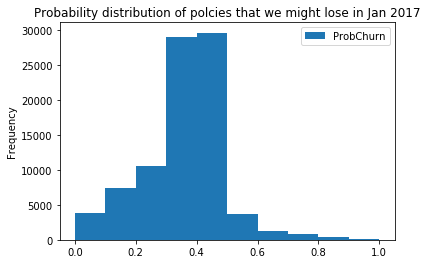

In [137]:
results.columns = ['PolicyId', 'ProbNotChurn', 'ProbChurn']
results[['ProbChurn']].plot.hist()
plt.title("Probability distribution of polcies that we might lose in Jan 2017")
plt.show()

In [124]:
print("Count of polcies with probabilty > 0.5 to be lost",len(results[results[1] > 0.5]))

Count of polcies with probabilty > 0.5 to be lost 6414


In [132]:
results[['PolicyId', 'ProbChurn']].to_csv("./data/results.csv",index=False)

In [128]:
results.head()

,PolicyId,ProbNotChurn,ProbChurn
0,92597.0,0.805835,0.194165
1,92808.0,0.878261,0.121739
2,93090.0,0.568288,0.431712
3,93122.0,0.756120,0.243880
4,93133.0,0.821059,0.178941


In [125]:
policy_df.columns

Index(['PolicyId', 'EnrollDate', 'CancelDate', 'MonthlyPremium',
       'ClaimedAmount', 'PaidAmount', 'CustomerPaidAmount', 'ClaimsCount',
       'AvgClaimAmount', 'AvgPaidAmount', 'AvgCustomerPaidAmount',
       'stdClaimAmount', 'stdPaidAmount', 'stdCustomerPaidAmount',
       'VarianceClaimAmount', 'VariancePaidAmount',
       'VarianceCustomerPaidAmount', 'maxClaimAmount', 'minClaimAmount',
       'medianClaimAmount', 'maxCustomerPaidAmount', 'minCustomerPaidAmount',
       'medianCustomerPaidAmount', 'LastSeenDate', 'LOS', 'InsuranceStatus'],
      dtype='object')